###SET UP

In [ ]:
# # Mounting google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
    print("Found GPU at: {}".format(device_name))
else:
    device_name = "/device:CPU:0"
    print("No GPU, using {}.".format(device_name))

No GPU, using /device:CPU:0.


In [ ]:
!pip install --upgrade scikit-learn


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation


###DATA COLLECTION

In [ ]:
# Load Tweet dataset# Load dataset file into a Pandas DataFrame
df = pd.read_csv("/content/drive/MyDrive/webmd.csv")
# Output first five rows
df.head()

,Age,Condition,Date,Drug,DrugId,EaseofUse,Effectiveness,Reviews,Satisfaction,Sex,Sides,UsefulCount
0,75 or over,Stuffy Nose,9/21/2014,25dph-7.5peh,146724,5,5,I'm a retired physician and of all the meds I ...,5,Male,"Drowsiness, dizziness , dry mouth /nose/thro...",0
1,25-34,Cold Symptoms,1/13/2011,25dph-7.5peh,146724,5,5,cleared me right up even with my throat hurtin...,5,Female,"Drowsiness, dizziness , dry mouth /nose/thro...",1
2,65-74,Other,7/16/2012,warfarin (bulk) 100 % powder,144731,2,3,why did my PTINR go from a normal of 2.5 to ov...,3,Female,,0
3,75 or over,Other,9/23/2010,warfarin (bulk) 100 % powder,144731,2,2,FALLING AND DON'T REALISE IT,1,Female,,0
4,35-44,Other,1/6/2009,warfarin (bulk) 100 % powder,144731,1,1,My grandfather was prescribed this medication ...,1,Male,,1


In [ ]:
# Map the numerical ratings to corresponding labels
label_map = {1: 'Negative', 2: 'Negative', 3: 'Neutral', 4: 'Positive', 5: 'Positive'}
df['sentiment'] = df['Satisfaction'].map(label_map)

In [ ]:
# Filter the dataset for negative reviews of 'cymbalta'
negative_reviews = df[(df['Drug'] == 'cymbalta') & (df['sentiment'] == 'Negative')]

# Output the filtered reviews
print(negative_reviews)


          Age                               Condition        Date      Drug  \
314216  45-54            Repeated Episodes of Anxiety   1/13/2020  cymbalta   
314235  35-44  Anxiousness associated with Depression   12/6/2019  cymbalta   
314246  55-64             Chronic Muscle or Bone Pain  11/20/2019  cymbalta   
314257  55-64  Anxiousness associated with Depression  11/19/2019  cymbalta   
314281  19-24               Major Depressive Disorder   9/29/2019  cymbalta   
...       ...                                     ...         ...       ...   
319076  25-34               Major Depressive Disorder   7/20/2008  cymbalta   
319077  35-44               Major Depressive Disorder   7/19/2008  cymbalta   
319080  35-44               Major Depressive Disorder   7/18/2008  cymbalta   
319082  35-44               Major Depressive Disorder   7/17/2008  cymbalta   
319085  25-34            Repeated Episodes of Anxiety   7/16/2008  cymbalta   

        DrugId  EaseofUse  Effectiveness  \
314216 

### DATA PREPROCESSING

In [ ]:

def preprocess_text(text):
    text = re.sub(r'\d+', '', text)  # Removing numbers
    text = re.sub(r'[^\w\s]', '', text)  # punctuation
    text = text.lower()  # Converting to lowercase
    text = text.split()  # Tokenizing text
    stop_words = set(stopwords.words('english'))
    text = [word for word in text if word not in stop_words]  #  stop words
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(word) for word in text]  # Lemmatization
    return ' '.join(text)

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# Loading preprocess the patient reviews data
negative_reviews['processed_reviews'] = negative_reviews['Reviews'].apply(preprocess_text)


<ipython-input-10-49d3939c45d8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_reviews['processed_reviews'] = negative_reviews['Reviews'].apply(preprocess_text)


###VECTORIZATION

In [ ]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(negative_reviews['processed_reviews'])


### TOPIC MODELING ALGORITHM - LDA

In [ ]:
# Step 3: Topic Modeling Algorithm (LDA)
lda_model = LatentDirichletAllocation(n_components=5, random_state=42)  #I chose 10 topics
lda_model.fit(X)


LatentDirichletAllocation(n_components=5, random_state=42)

###TOPIC INTERPRETATION

In [ ]:

def get_top_words(model, feature_names, n_top_words):
    top_words = []
    for topic_idx, topic in enumerate(model.components_):
        top_words_indices = topic.argsort()[:-n_top_words - 1:-1]
        top_words.append([feature_names[i] for i in top_words_indices])
    return top_words

feature_names = vectorizer.get_feature_names_out()
top_words = get_top_words(lda_model, feature_names, 5)  # Number of top words per topic


In [ ]:
print(top_words)

[['tolerate', 'czay', 'palpation', 'compounding', 'wore'], ['cymbalta', 'pain', 'drug', 'taking', 'mg'], ['drugit', 'ached', 'whoowa', 'intensify', 'seizer'], ['dirreha', 'lbp', 'blister', 'helpingi', 'raised'], ['heartburn', 'suck', 'tremerors', 'space', 'migranes']]


###TOPIC ASSIGNMENT

In [ ]:
topic_assignments = lda_model.transform(X)
negative_reviews['topic'] = np.argmax(topic_assignments, axis=1)


<ipython-input-16-7b6a8cf1988c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_reviews['topic'] = np.argmax(topic_assignments, axis=1)


In [ ]:
print(topic_assignments)

[[0.03373514 0.86492814 0.03373737 0.0338642  0.03373514]
 [0.03259049 0.86963696 0.03259041 0.03259178 0.03259036]
 [0.0359887  0.85604501 0.03598866 0.03598894 0.03598868]
 ...
 [0.04945531 0.66488563 0.04945516 0.04945748 0.18674641]
 [0.04107995 0.83567956 0.04107992 0.0410807  0.04107987]
 [0.10606798 0.80866178 0.02842145 0.02842737 0.02842142]]


In [ ]:
print(negative_reviews.head())

          Age                               Condition        Date      Drug  \
314216  45-54            Repeated Episodes of Anxiety   1/13/2020  cymbalta   
314235  35-44  Anxiousness associated with Depression   12/6/2019  cymbalta   
314246  55-64             Chronic Muscle or Bone Pain  11/20/2019  cymbalta   
314257  55-64  Anxiousness associated with Depression  11/19/2019  cymbalta   
314281  19-24               Major Depressive Disorder   9/29/2019  cymbalta   

        DrugId  EaseofUse  Effectiveness  \
314216   91491          3              1   
314235   91491          3              3   
314246   91491          2              2   
314257   91491          3              3   
314281   91491          2              1   

                                                  Reviews  Satisfaction  \
314216  I was prescribed Cymbalta for anxiety and star...             1   
314235  Bipolar I with a neck fusion. Pdoc prescribed ...             2   
314246  I have depression, anxiety,

###VISUALIZATION

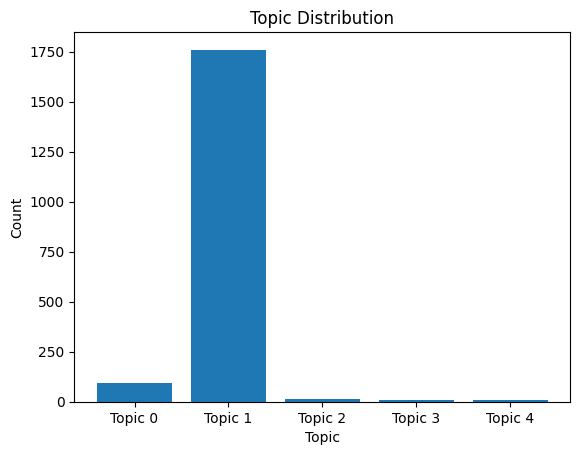

In [ ]:
# Step 8: Visualization (Optional)
import matplotlib.pyplot as plt

topic_labels = ['Topic {}'.format(i) for i in range(lda_model.n_components)]
topic_counts = negative_reviews['topic'].value_counts().sort_index()

plt.bar(topic_labels, topic_counts)
plt.xlabel('Topic')
plt.ylabel('Count')
plt.title('Topic Distribution')
plt.show()

###PERFORMING CLUSTERING OF DOCUMENTS

In [ ]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from wordcloud import WordCloud

In [ ]:
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(topic_assignments)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


###Cluster Analysis

In [ ]:
# Step 3: Cluster Analysis
# Compute cluster statistics
cluster_counts = {}
for cluster_label in range(kmeans.n_clusters):
    cluster_counts[cluster_label] = len(np.where(clusters == cluster_label)[0])

# Print cluster statistics
for cluster_label, count in cluster_counts.items():
    print(f"Cluster {cluster_label}: {count} reviews")


Cluster 0: 1672 reviews
Cluster 1: 210 reviews


###Cluster Visualization

####Word clouds

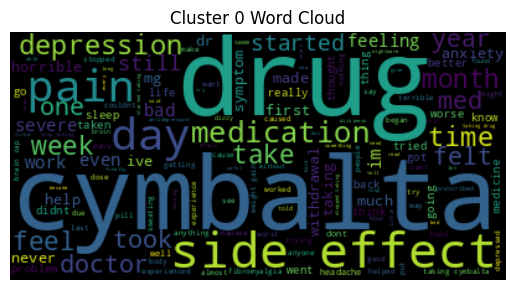

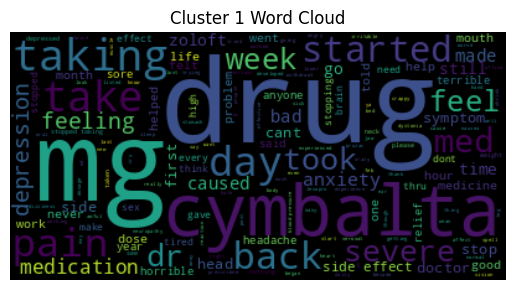

In [ ]:
# Step 4: Generate word clouds for each cluster
for cluster_label in range(kmeans.n_clusters):
    cluster_docs = np.where(clusters == cluster_label)[0]
    cluster_text = [negative_reviews['processed_reviews'].iloc[doc_id] for doc_id in cluster_docs]
    cluster_wordcloud = WordCloud().generate(' '.join(cluster_text))
    plt.figure()
    plt.imshow(cluster_wordcloud, interpolation='bilinear')
    plt.title(f'Cluster {cluster_label} Word Cloud')
    plt.axis('off')
    plt.show()


###Scatterplot

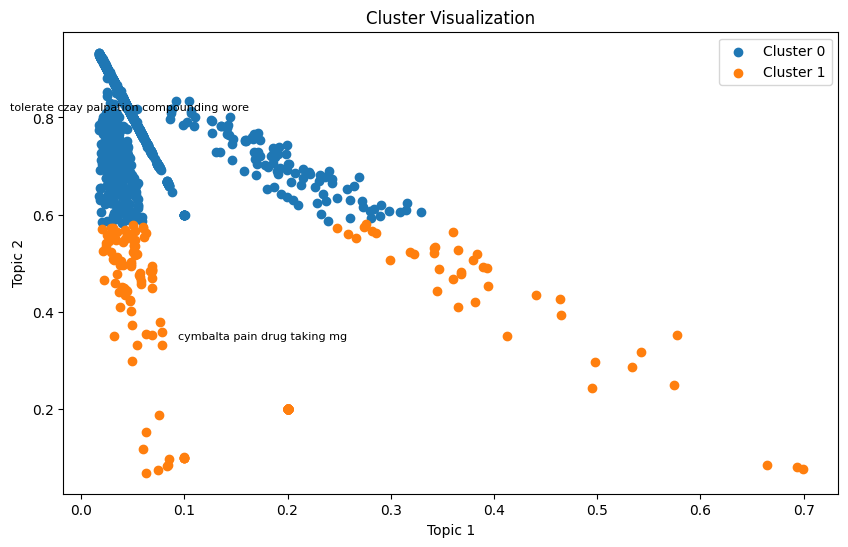

In [ ]:
import matplotlib.pyplot as plt

# Plotting the clusters
plt.figure(figsize=(10, 6))
for cluster_label in range(kmeans.n_clusters):
    cluster_docs = np.where(clusters == cluster_label)[0]
    cluster_text = [negative_reviews['processed_reviews'].iloc[doc_id] for doc_id in cluster_docs]
    cluster_wordcloud = ' '.join(cluster_text)
    plt.scatter(topic_assignments[cluster_docs, 0], topic_assignments[cluster_docs, 1], label=f'Cluster {cluster_label}')

    # Displaying top words in each cluster
    top_words_cluster = ' '.join(top_words[cluster_label])
    plt.annotate(top_words_cluster, (np.mean(topic_assignments[cluster_docs, 0]), np.mean(topic_assignments[cluster_docs, 1])), fontsize=8, ha='center')

plt.legend()
plt.xlabel('Topic 1')
plt.ylabel('Topic 2')
plt.title('Cluster Visualization')
plt.show()



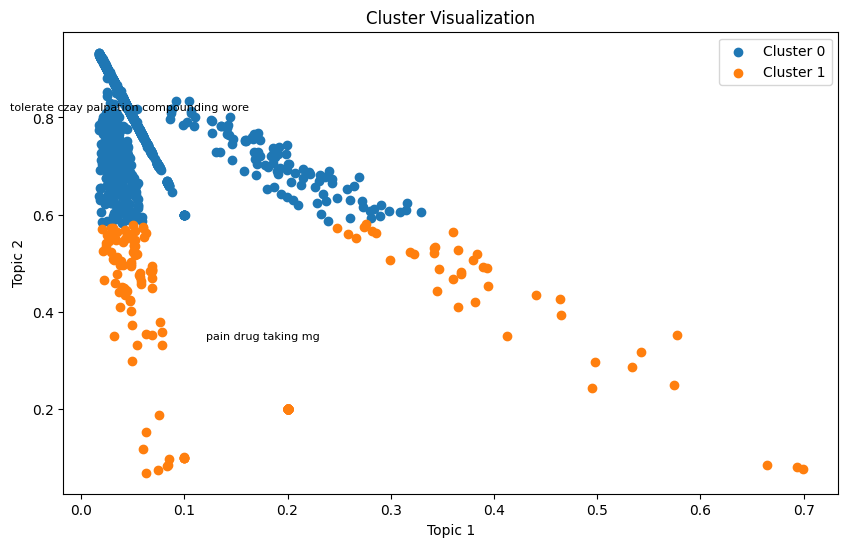

In [ ]:
import matplotlib.pyplot as plt

# Plotting the clusters
plt.figure(figsize=(10, 6))
for cluster_label in range(kmeans.n_clusters):
    cluster_docs = np.where(clusters == cluster_label)[0]
    cluster_text = [negative_reviews['processed_reviews'].iloc[doc_id] for doc_id in cluster_docs]
    cluster_wordcloud = ' '.join(cluster_text)
    plt.scatter(topic_assignments[cluster_docs, 0], topic_assignments[cluster_docs, 1], label=f'Cluster {cluster_label}')

    # Removing 'cymbalta' from the top words list
    top_words_cluster = [word for word in top_words[cluster_label] if word.lower() != 'cymbalta']
    top_words_cluster = top_words_cluster[:5]  # Get top 5 words
    top_words_cluster = ' '.join(top_words_cluster)
    plt.annotate(top_words_cluster, (np.mean(topic_assignments[cluster_docs, 0]), np.mean(topic_assignments[cluster_docs, 1])), fontsize=8, ha='center')

plt.legend()
plt.xlabel('Topic 1')
plt.ylabel('Topic 2')
plt.title('Cluster Visualization')
plt.show()


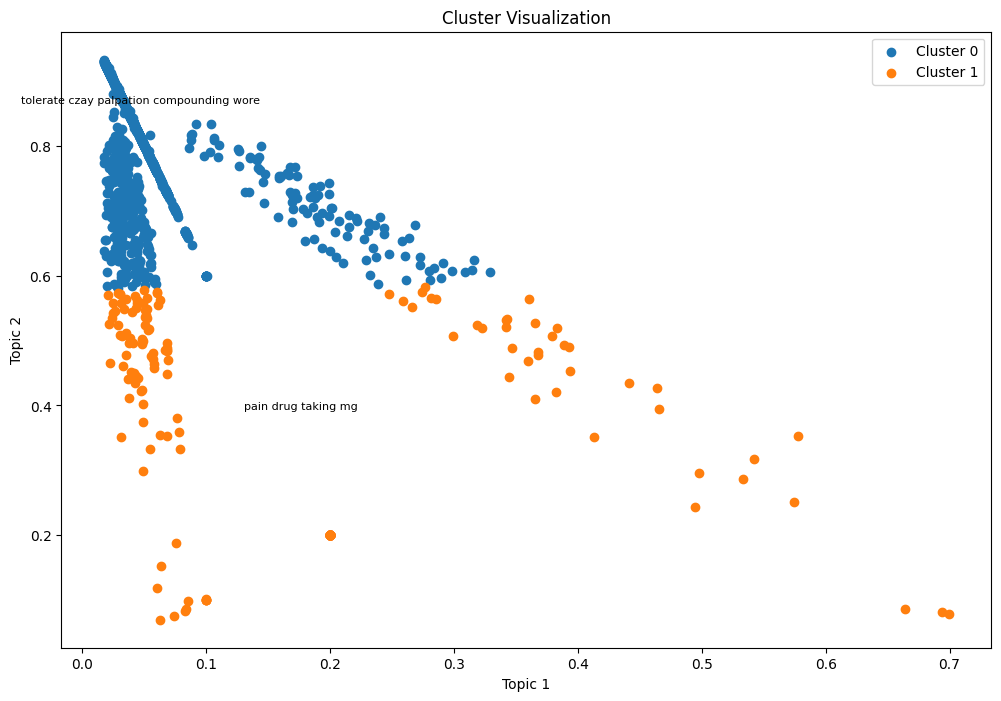

In [ ]:
import matplotlib.pyplot as plt

# Plotting the clusters
plt.figure(figsize=(12, 8))
for cluster_label in range(kmeans.n_clusters):
    cluster_docs = np.where(clusters == cluster_label)[0]
    cluster_text = [negative_reviews['processed_reviews'].iloc[doc_id] for doc_id in cluster_docs]
    cluster_wordcloud = ' '.join(cluster_text)
    plt.scatter(topic_assignments[cluster_docs, 0], topic_assignments[cluster_docs, 1], label=f'Cluster {cluster_label}')

    # Removing 'cymbalta' from the top words list
    top_words_cluster = [word for word in top_words[cluster_label] if word.lower() != 'cymbalta']
    top_words_cluster = top_words_cluster[:5]  # Get top 5 words
    top_words_cluster = ' '.join(top_words_cluster)

    # Adjusting the annotation position
    x_mean = np.mean(topic_assignments[cluster_docs, 0])
    y_mean = np.mean(topic_assignments[cluster_docs, 1])
    if y_mean > 0.9:
        y_offset = -0.05
    else:
        y_offset = 0.05
    plt.annotate(top_words_cluster, (x_mean, y_mean + y_offset), fontsize=8, ha='center')

plt.legend()
plt.xlabel('Topic 1')
plt.ylabel('Topic 2')
plt.title('Cluster Visualization')
plt.show()
